In [28]:
import datetime as dt
from pytz import timezone
from matplotlib import pyplot as plt
import pandas as pd
from IPython.display import HTML
from money_squirrel.bin import utils

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 7)

COINS = utils.load_config("coins")

def display_all(df):
    return HTML(df.to_html())

2017-06-26 05:53:15,738|money_squirrel.bin.utils|INFO|Loading JSON from /Users/ravdek/code/money_squirrel/money_squirrel/config/coins.json


In [32]:
gdax_price = utils.query_pg("select * from gdax_api_quote")

2017-06-26 16:25:09,205|money_squirrel.bin.utils|INFO|Loading JSON from /Users/ravdek/code/money_squirrel/money_squirrel/config/postgres.json
2017-06-26 16:25:09,206|money_squirrel.bin.utils|INFO|Connecting to postgres DB @ localhost
2017-06-26 16:25:09,210|money_squirrel.bin.utils|INFO|Executing query:

select * from gdax_api_quote



In [33]:
gdax_price.head()

,id,product_id,granularity,dt,low,high,open,close,volume
0,1,BTC-USD,20,2017-06-25 23:39:20-07:00,2489.36,2489.71,2489.47,2489.36,4.232061
1,2,BTC-USD,20,2017-06-25 23:38:40-07:00,2488.17,2489.96,2488.17,2489.96,0.102200
2,3,BTC-USD,20,2017-06-25 23:38:20-07:00,2486.56,2489.96,2487.47,2489.96,2.362538
3,4,BTC-USD,20,2017-06-25 23:38:00-07:00,2486.24,2489.97,2486.24,2489.97,4.472527
4,5,BTC-USD,20,2017-06-25 23:37:40-07:00,2486.11,2487.67,2486.11,2486.16,2.713689


In [34]:
gdax_price['granularity'].value_counts()

60    271247
20        43
Name: granularity, dtype: int64

In [35]:
gdax_price.loc[0, 'dt'].__class__

pandas.tslib.Timestamp

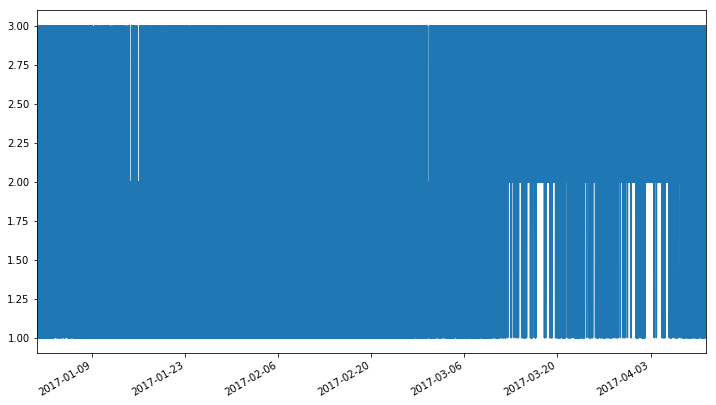

In [36]:
gdax_price.loc[gdax_price['granularity']==60, 'dt'].value_counts().plot()

In [37]:
gdax_price.loc[gdax_price['granularity']==60, 'dt'].max().replace(tzinfo=timezone('UTC'))

datetime.datetime(2017, 4, 11, 9, 39, tzinfo=<UTC>)

In [20]:
gdax_price.dt.isnull().value_counts()

False    1680354
Name: dt, dtype: int64

In [38]:
import requests

In [40]:
params = {'start': '2017-04-11T16:40:00', 'end': '2017-04-11T16:40:00', 'granularity': 60}
product_id = "BTC-USD"
url = "https://api.gdax.com"
r = requests.get(url + '/products/{}/candles'
                 .format(product_id), params=params)

In [42]:
r.json()

[[1491940740, 1222.54, 1222.54, 1222.54, 1222.54, 1.7439713399999999],
 [1491940680, 1222.18, 1222.6, 1222.18, 1222.6, 6.8085213300000005],
 [1491940620, 1222, 1222.18, 1222, 1222.18, 3.0252489699999994],
 [1491940560, 1221.94, 1222, 1221.94, 1222, 1.50503718],
 [1491940500, 1221.87, 1221.94, 1221.87, 1221.92, 4.54007768],
 [1491940440, 1221.79, 1221.82, 1221.82, 1221.79, 3.0156],
 [1491940380, 1221.81, 1221.82, 1221.82, 1221.81, 1.4062798300000001],
 [1491940320, 1221.17, 1221.84, 1221.84, 1221.17, 4.4135],
 [1491940260, 1221.51, 1221.76, 1221.52, 1221.76, 2.51047068],
 [1491940200, 1221.51, 1221.52, 1221.51, 1221.52, 3.7954000000000003],
 [1491940140, 1221.51, 1221.52, 1221.51, 1221.51, 1.9060717],
 [1491940080, 1221.51, 1221.52, 1221.52, 1221.51, 2.7252554499999997],
 [1491940020, 1221.51, 1221.52, 1221.51, 1221.52, 0.4005],
 [1491939960, 1221.51, 1221.52, 1221.51, 1221.52, 1.5017],
 [1491939900, 1221.5, 1221.52, 1221.5, 1221.52, 1.7600156700000003],
 [1491939840, 1221.43, 1221.48, 